In [227]:
#Install Fitter module
#!pip install Fitter
#!pip install ruptures

In [406]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import logging
import sys
import os
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from fitter import Fitter, get_common_distributions
import ruptures as rpt
import statsmodels.tsa.stattools as ts

In [56]:
# --- Configuration ---
# Robustly determine the project root directory

#SCRIPT_DIR = Path(__file__).resolve().parent
SCRIPT_DIR = Path(os.getcwd()).resolve()/"script"
PROJECT_ROOT = SCRIPT_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

Common scripts 

In [14]:
def fix_timestamp(df):
                # Fix timestamp corruption (seconds sometimes interpreted as milliseconds)
                for col in df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if pd.api.types.is_datetime64_any_dtype(df[col]):
                            if not df[col].empty and df[col].max() < pd.Timestamp("2020-01-01"):
                                logging.info(f"  Fixing corrupted timestamps in column: {col}")
                                # Scale up by 1000 to correct seconds-as-ms bug.
                                # Use astype('datetime64[ns]') to ensure we are working with nanoseconds
                                # before scaling, then convert back.
                                ns_values = df[col].values.astype("datetime64[ns]").astype("int64")
                                df[col] = pd.to_datetime(ns_values * 1000)
                                
                            # Enforce 2020+ constraint (replace placeholders/zeros with NaT)
                            if not df[col].empty:
                                mask = df[col] < pd.Timestamp("2020-01-01")
                                if mask.any():
                                    df.loc[mask, col] = pd.NaT 


def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    plot_acf(timeseries, ax=ax1, lags=75)
    plot_pacf(timeseries, ax=ax2, lags=75)
    plt.show()

# Analysis based on BTC data 


In [286]:
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR=Path("C:/monu/georgiatech/practicum/trilemma/bitcoin3/bitcoin-analytics-capstone-template/data/")
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

In [74]:
df_btc = pd.read_csv(COINMETRICS_PATH)
df_btc["time"] = pd.to_datetime(df_btc["time"])
df_btc.set_index("time", inplace=True)
df_btc.index = df_btc.index.normalize().tz_localize(None)

# Remove duplicates and sort
df_btc = df_btc.loc[~df_btc.index.duplicated(keep="last")].sort_index()
#df_btc=df_btc.dropna()
df_btc.head(2)

,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
time,,,,,,,,,,,,,,,,,,,,,
2009-01-03,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2009-01-04,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN


Describe the data.

In [77]:
df_btc.describe()

,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
count,6.220000e+03,6.220000e+03,6.220000e+03,6.220000e+03,6220.000000,5659.000000,5.659000e+03,2.398000e+03,6220.000000,6220.000000,...,7.000000,7.000000,7.000000,6.220000e+03,6.220000e+03,5.659000e+03,6.214000e+03,6220.000000,6.220000e+03,5.659000e+03
mean,5.009057e+05,2.080860e+07,1.636422e+09,1.636422e+09,149.868810,1.989795,3.826396e+11,8.633915e+11,48.228897,25838.964889,...,29.161564,78563.321591,91487.781788,1.419667e+07,9.479984e+05,4.012445e+10,1.979521e+07,208414.228457,4.971118e+05,5.116673e+09
std,3.794394e+05,1.958234e+07,4.220227e+07,4.220227e+07,30.743195,2.493876,5.873727e+11,6.398350e+11,91.173237,24373.197547,...,0.295175,1441.867173,1711.761816,5.794621e+06,8.181572e+05,7.342693e+10,1.037226e+06,170293.817001,3.733056e+05,7.584967e+09
min,0.000000e+00,0.000000e+00,1.614335e+09,1.614335e+09,0.000000,0.386829,1.776705e+05,9.058570e+10,0.000000,0.000000,...,28.686314,77790.505193,90406.142411,0.000000e+00,0.000000e+00,0.000000e+00,1.707025e+07,0.000000,0.000000e+00,0.000000e+00
25%,6.069600e+04,1.374226e+06,1.614336e+09,1.614336e+09,137.000000,1.294023,3.672256e+09,3.553683e+11,8.206849,9739.439215,...,28.988983,77950.803938,90628.404772,1.100396e+07,8.793724e+04,8.975455e+07,1.916582e+07,47152.500000,1.043238e+05,1.057649e+07
50%,5.968805e+05,1.830680e+07,1.614337e+09,1.614337e+09,150.000000,1.754254,9.793110e+10,6.989680e+11,19.542053,21445.549012,...,29.300019,78130.277588,91096.916155,1.643875e+07,8.140561e+05,7.592223e+09,2.019138e+07,224415.500000,5.578790e+05,1.349240e+09
75%,8.175268e+05,3.851661e+07,1.634030e+09,1.634030e+09,162.000000,2.256760,5.545583e+11,1.237536e+12,45.831708,34086.280950,...,29.340685,78152.300810,91175.053055,1.884127e+07,1.533906e+06,4.227143e+10,2.062572e+07,312607.500000,7.981745e+05,8.188261e+09
max,1.366494e+06,5.592428e+07,1.768360e+09,1.768360e+09,692.000000,146.038332,2.487865e+12,2.487527e+12,1495.748916,284367.709273,...,29.485280,81816.258857,95304.498294,1.997535e+07,2.805575e+06,3.345030e+11,2.082639e+07,928131.000000,2.041653e+06,7.478639e+10


<b>Plot the BTC data.</b>

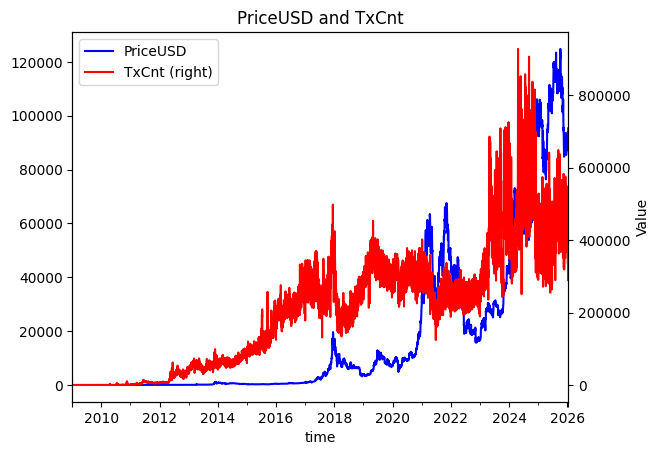

In [112]:
df2 = df_btc[['PriceUSD','CapMVRVCur','TxCnt']]
ax = df2.plot(y='PriceUSD', label='PriceUSD', color='blue')
df2.plot(y='TxCnt', label='TxCnt', color='red', ax=ax, secondary_y=True)
plt.title('PriceUSD and TxCnt')
plt.xlabel('Index')
plt.ylabel('Value')
#plt.legend()
plt.show()

<b>Do a seasonal decomposition using Multiplicative model and plot the data </b>

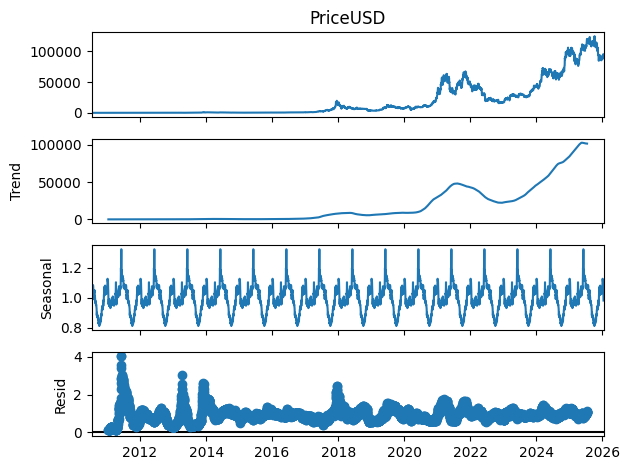

In [96]:
result = seasonal_decompose(df_btc['PriceUSD'].dropna(), model='multiplicative', period=365)  # Adjust period based on your data

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Save the results in decomposition_results with the column name as the key
decomposition_results = {
    'Close': {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
}

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

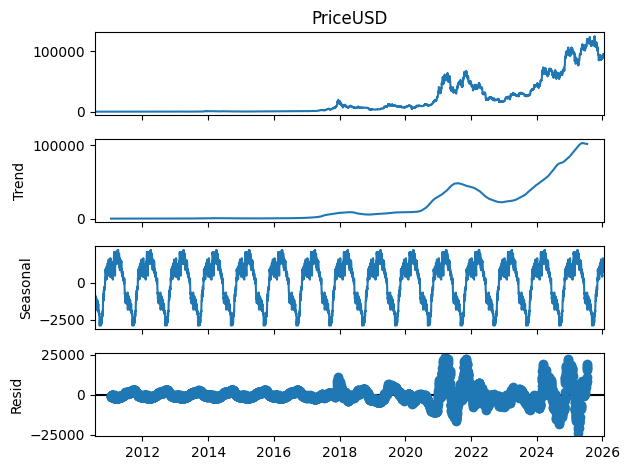

In [98]:
result = seasonal_decompose(df_btc['PriceUSD'].dropna(), model='additive', period=365)  # Adjust period based on your data

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Save the results in decomposition_results with the column name as the key
decomposition_results = {
    'Close': {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
}

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

Based on the residuals looks like multiplicative seems to be better. We see that there is a seasonal pattern.

<b>Plot of Moving averages of PriceUSD using log scale</b>

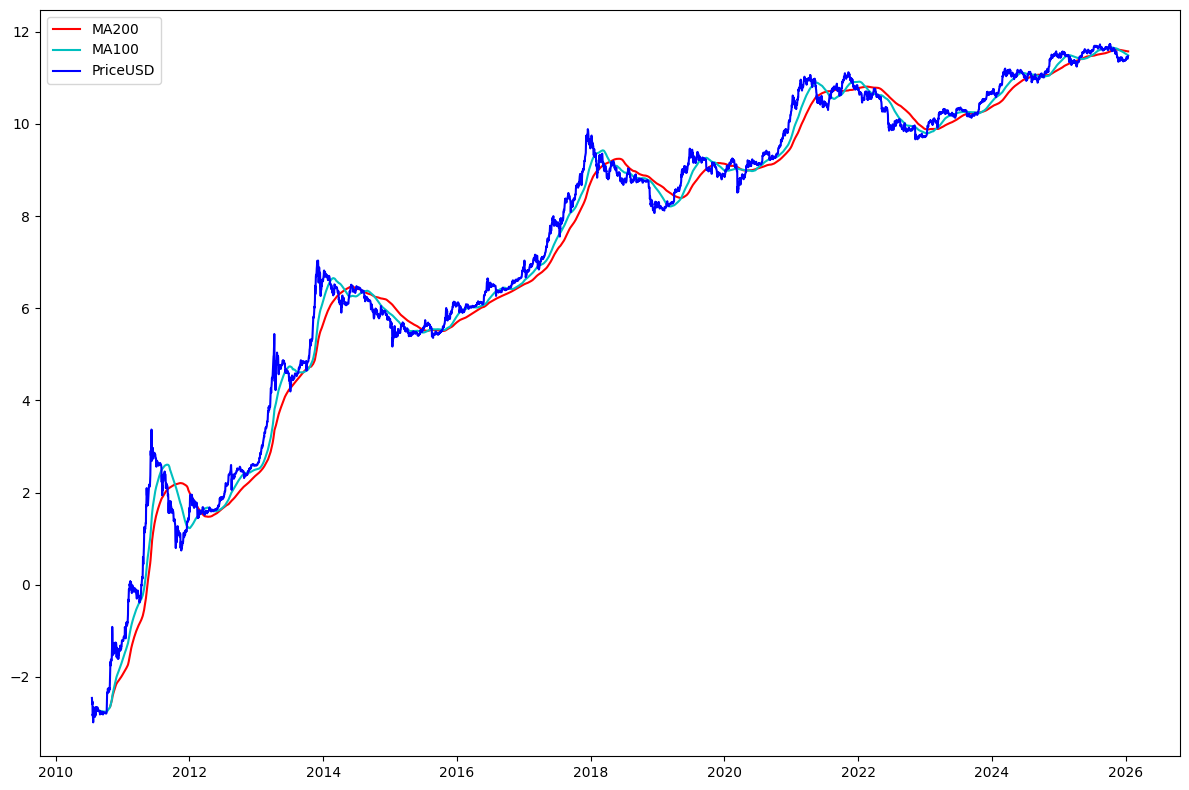

In [119]:
MA_WINDOW_200=200

ma_200 = df_btc['PriceUSD'].rolling(MA_WINDOW_200, min_periods=MA_WINDOW_200 // 2).mean()

MA_WINDOW_100=100
ma_100 = df_btc['PriceUSD'].rolling(MA_WINDOW_100, min_periods=MA_WINDOW_100 // 2).mean()
plt.figure(figsize=(12, 8))
plt.plot(np.log(ma_200), color='r', label='MA200')
plt.plot(np.log(ma_100), color='c', label='MA100')
plt.plot(np.log(df_btc['PriceUSD']), color='b', label='PriceUSD')
plt.legend()
plt.tight_layout()
plt.show()

From the above plot we see that when Moving average for 100 is above Moving average for 200, then the Price increases. When MA_100 is less than MA_200 then priceUSD drops.

<b>Check autocorrelation and stationarity of BTC PriceUSD data.</b>

PriceUSD is not stationary but first difference of PriceUSD is stationary.

In [122]:
px=df_btc['PriceUSD'].dropna()
check_stationarity(px)

ADF Statistic: -0.313816
p-value: 0.923525
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


In [125]:
px=df_btc['PriceUSD'].diff().dropna()
check_stationarity(px)

ADF Statistic: -11.262268
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


Plot the autocorrelation. There is a partial autocorrelation with periods 1,8,9

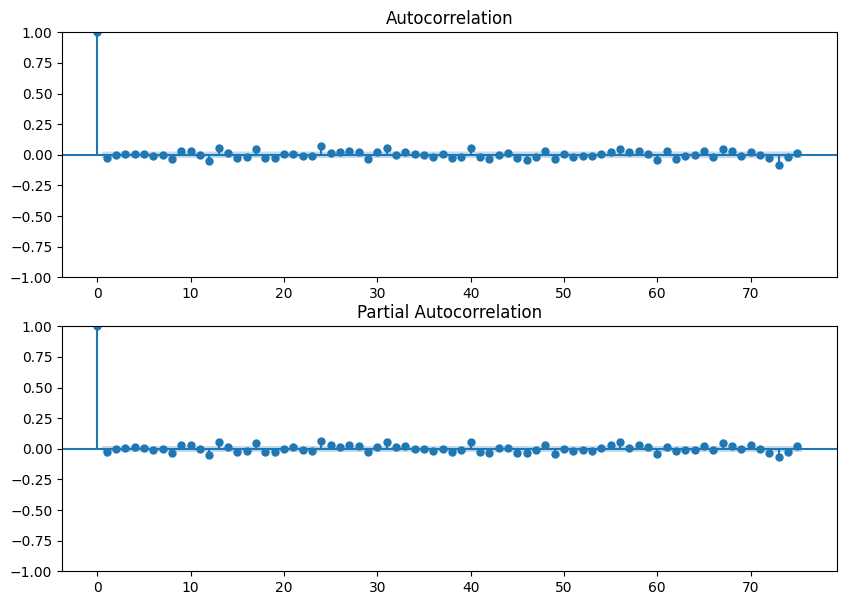

In [127]:
plot_acf_pacf(px)

<b>Plot the distribution of PriceUSD and try to get the bet fit for the data</b>
<br>
We see the PriceUSD follows  cauchy distribution/log normal distribution.

C:\Users\bpree\AppData\Local\Temp\ipykernel_24080\2658096587.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  f = Fitter(df_btc['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())


          sumsquare_error          aic          bic  kl_div  ks_statistic  \
cauchy           8.456708   429.153821   442.435826     inf      0.029961   
lognorm        260.896725  3596.647346  3616.570353     inf      0.128328   
norm           263.087028  3601.416363  3614.698368     inf      0.128935   
exponpow       685.316888  3176.791248  3196.714255     inf      0.343573   
rayleigh       856.809941    68.539607    81.821612     inf      0.478622   

             ks_pvalue  
cauchy    7.576113e-05  
lognorm   1.052510e-81  
norm      1.769834e-82  
exponpow  0.000000e+00  
rayleigh  0.000000e+00  
Best fitting distribution: uniform


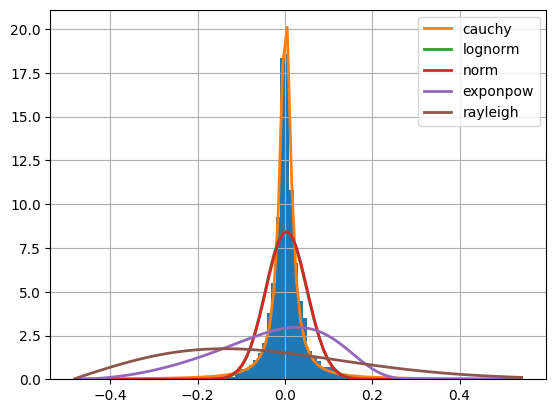

In [140]:
# Fit the data to common distributions
f = Fitter(df_btc['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())
f.fit()

# Print a summary of the best-fitting distributions
print(f.summary()) 

# You can also get the best fit distribution name and parameters
best_dist = f.get_best(method='aic') # 'aic', 'bic', or 'sumsquare_error'
print(f"Best fitting distribution: {list(best_dist.keys())[0]}")

Try to find distribution for year 2024/2025. We see the same distribution of data.

         sumsquare_error         aic         bic  kl_div  ks_statistic  \
cauchy        844.866424 -140.729189 -132.934881     inf      0.053277   
norm         1284.375181   18.710351   26.504658     inf      0.064815   
lognorm      1288.359162   13.764491   25.455953     inf      0.068469   
gamma        1296.753282   10.807883   22.499345     inf      0.071118   
chi2         1353.309819   -0.276458   11.415004     inf      0.080921   

         ks_pvalue  
cauchy    0.243989  
norm      0.089857  
lognorm   0.062853  
gamma     0.047917  
chi2      0.016050  
Best fitting distribution: uniform


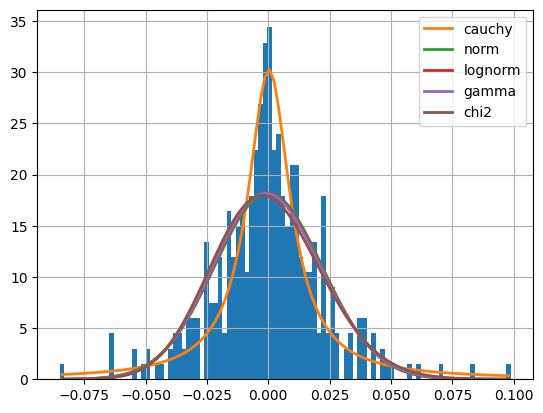

In [149]:
#Check the same for a given year. 
df_btc_2025=df_btc[df_btc.index.year == 2025]
f = Fitter(df_btc_2025['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())
f.fit()

# Print a summary of the best-fitting distributions
print(f.summary()) 

# You can also get the best fit distribution name and parameters
best_dist = f.get_best(method='aic') # 'aic', 'bic', or 'sumsquare_error'
print(f"Best fitting distribution: {list(best_dist.keys())[0]}")

<b>Correlation analysis and Autocorrelation based on timeseries data for year 2025. </b>
<br>
We see that correlation between PriceUSD and HashRate,TxCnt is much less during 2025 than historical correlation. This is very true for financial markets where correlation changes with time. We can see the plot of correlation between PriceUSD and HashRate for the various years.

In [155]:
correlation_cols = ["PriceUSD", "CapMrktCurUSD", "HashRate", "TxCnt"]
correlation_matrix = df_btc_2025[correlation_cols].corr()
print(correlation_matrix)

               PriceUSD  CapMrktCurUSD  HashRate     TxCnt
PriceUSD       1.000000       0.999821  0.211227  0.174687
CapMrktCurUSD  0.999821       1.000000  0.225319  0.181621
HashRate       0.211227       0.225319  1.000000  0.562812
TxCnt          0.174687       0.181621  0.562812  1.000000


In [162]:
correlation_cols = ["PriceUSD", "CapMrktCurUSD", "HashRate", "TxCnt"]
correlation_matrix = df_btc[correlation_cols].corr()
print(correlation_matrix)
correlation_matrix["PriceUSD"]["HashRate"]

               PriceUSD  CapMrktCurUSD  HashRate     TxCnt
PriceUSD       1.000000       0.999698  0.931277  0.661398
CapMrktCurUSD  0.999698       1.000000  0.937076  0.657791
HashRate       0.931277       0.937076  1.000000  0.710628
TxCnt          0.661398       0.657791  0.710628  1.000000


0.9312774704411197

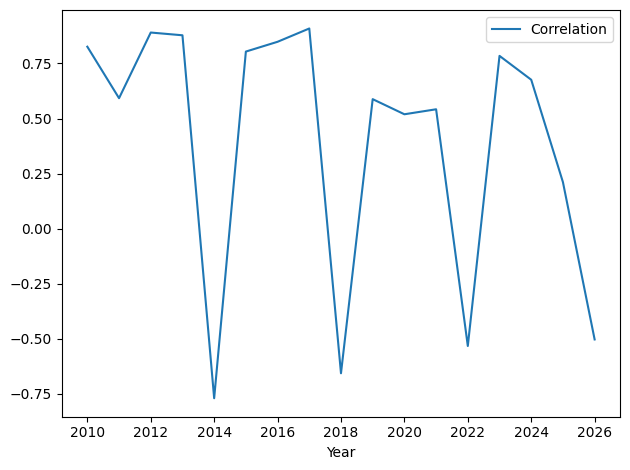

In [210]:
tmp=[]
years=[]
for year in df_btc.index.year.unique():
    #print(year)
    df_btc_year=df_btc[df_btc.index.year == year]
    correlation_matrix = df_btc_year[correlation_cols].corr()
    #print(correlation_matrix)
    tmp.append(correlation_matrix["PriceUSD"]["HashRate"])
    years.append(year)

my_dict = {
    'Year': years,
    'Correlation': tmp
}

# Create the DataFrame

df_2d = pd.DataFrame(my_dict)
df_2d.set_index('Year', inplace=True)

df_2d.plot()
plt.legend()
plt.tight_layout()
plt.show()

Check the BVAR regression.

In [214]:
tmp = df_btc_2025[correlation_cols]
tmp = tmp.diff().dropna()
model = VAR(tmp)
for i in range(1,20):

    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  110.82259264439965
BIC :  111.03716029367044
FPE :  1.3478559574545303e+48
HQIC:  110.90788225635326 

Lag Order = 2
AIC :  110.71826355123758
BIC :  111.10527789274512
FPE :  1.2143635138228975e+48
HQIC:  110.87211583867118 

Lag Order = 3
AIC :  110.74684831020132
BIC :  111.30701909644317
FPE :  1.2496811945040263e+48
HQIC:  110.9695596950449 

Lag Order = 4
AIC :  110.75530608869215
BIC :  111.4893479612994
FPE :  1.260492866450634e+48
HQIC:  111.04717505555303 

Lag Order = 5
AIC :  110.73177791662009
BIC :  111.6404104532023
FPE :  1.2314942975043448e+48
HQIC:  111.09310503243765 

Lag Order = 6
AIC :  110.74111591181259
BIC :  111.82506367337703
FPE :  1.2435152239662285e+48
HQIC:  111.17220384575019 

Lag Order = 7
AIC :  110.7037880943532
BIC :  111.96378067330681
FPE :  1.1985814481435176e+48
HQIC:  111.20494163793069 

Lag Order = 8
AIC :  110.73550907989603
BIC :  112.17228114863892
FPE :  1.2380773647831042e+48
HQIC:  111.30703516736627 

Lag Order = 9

In [216]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Feb, 2026
Time:                     11:15:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    111.964
Nobs:                     357.000    HQIC:                   111.205
Log likelihood:          -21670.9    FPE:                1.19858e+48
AIC:                      110.704    Det(Omega_mle):     8.76983e+47
--------------------------------------------------------------------
Results for equation PriceUSD
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                 -218.724652       177.220993           -1.234           0.217
L1.PriceUSD            -49.545646        23.014903           -2.153           0.031
L1.CapMrktCurUSD         0.000002         0.0

We see that there is no autocorrelation based on timeseries data. (CapMrktCurUSD is a scaled version of PriceUSD)

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).
If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model.
Durbin Watson’s Statistic is close to 2, then there is no significant serial correlation. 

In [219]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(tmp.columns, out):
    print((col), ':', round(val, 2))

PriceUSD : 1.99
CapMrktCurUSD : 1.99
HashRate : 2.0
TxCnt : 2.01


<b>
#Install ruptures library if needed
<br>
#!pip install ruptures
</b>

[55, 110, 125, 190, 230, 275, 285, 305, 315, 320, 365]


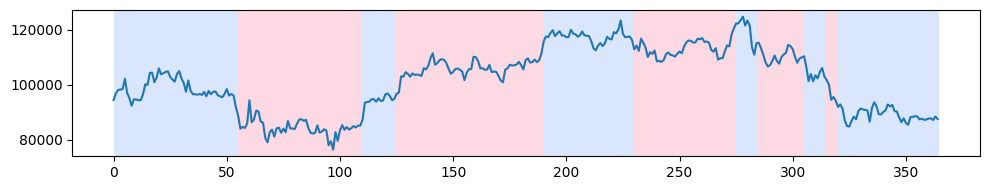

In [231]:
px=df_btc_2025['PriceUSD'].to_numpy()
algo = rpt.Dynp(model="l2").fit(px)
result = algo.predict(n_bkps=10)
print(result)
rpt.display(df_btc_2025['PriceUSD'],  result)
plt.show()

Determine the points where there is a regime change.

C:\ProgramData\anaconda3-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


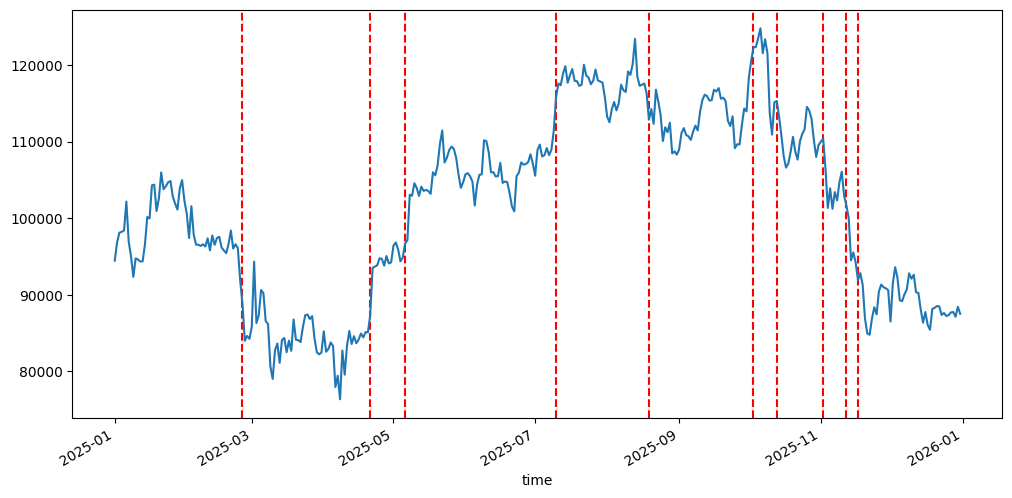

In [238]:
cnt=0
plt.figure(figsize=(12, 6))
for r in result[:-1]:
    plt.axvline(x=df_btc_2025.iloc[result[:-1]].index[cnt], color='red', linestyle='--', label='Regime change')
    cnt+=1

df_btc_2025['PriceUSD'].plot()
plt.show()

These are the dates where there is a regime change.

In [241]:
df_btc_2025.iloc[result[:-1]].index

DatetimeIndex(['2025-02-25', '2025-04-21', '2025-05-06', '2025-07-10',
               '2025-08-19', '2025-10-03', '2025-10-13', '2025-11-02',
               '2025-11-12', '2025-11-17'],
              dtype='datetime64[ns]', name='time', freq=None)

<table>
  <caption><b>Market events for regime change dates</b></caption>
  <thead>
    <tr>
      <th>Date</th>
      <th>Event</th>
      <th>Link</th>  
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>25-02-2025</td>
      <td>Nasdaq falls for 4th straight day.</td>
      <td>https://www.investopedia.com/dow-jones-today-02252025-11685876</td>  
    </tr>
    <tr>
      <td>2025-04-21</td>
      <td>Stocks Fall Sharply as Trump Ramps Up Criticism of Fed Chair Powell; Dollar Slides to 3-Year Low, Gold Jumps to New High</td>
        <td>https://www.investopedia.com/dow-jones-today-04212025-11718673</td>
    </tr>
    <tr>
      <td>2025-07-10</td>
      <td>Nasdaq Hit New Highs as Airline Stocks Soar After Strong Delta Earnings; Bitcoin Surges to Record</td>
        <td>https://www.investopedia.com/dow-jones-today-07102025-11769518</td>
    </tr>
    <tr>
      <td>2025-08-19</td>
      <td>Nasdaq Fall as Tech Stocks Tumble,Dow Closes Little Changed After Touching All-Time High</td>
        <td>https://www.investopedia.com/dow-jones-today-08192025-11793339</td>
    </tr>
   <tr>
      <td>2025-10-13</td>
      <td>Stocks Close Sharply Higher as Trump Softens Tone on China; Chip Shares Soar on Broadcom Deal With OpenAI</td>
        <td>https://www.investopedia.com/dow-jones-today-10132025-11828817</td>
    </tr>
    <tr>
      <td>2025-11-12</td>
      <td>Dow Closes Above 48000 for the First Time Ahead of House Vote to End US Government Shutdown; Nasdaq Slips</td>
        <td>https://www.investopedia.com/dow-jones-today-11122025-11847653</td>
    </tr>
    <tr>
      <td>2025-11-17</td>
      <td>Stock Indexes Close Down Sharply Ahead of Nvidia, Retail Results; Dow Sheds 550 Points; Google Parent Hits Record High</td>
        <td>https://www.investopedia.com/dow-jones-today-11172025-11850528</td>
    </tr>
      
  </tbody>
</table>


<b>This suggests a probable correlation with SP500. Hence we check with SP500 data for 2025.</b>

<br>
Open a New Google Sheet and Enter the Formula: In cell A1, enter the following formula to get the last ~15 years of daily data:
<br>
=GOOGLEFINANCE("INDEXSP:.INX", "all", DATE(2010,1,1), TODAY())
<br>


In [260]:
sp_file=DATA_DIR/"SP500.csv"
df_sp500 = pd.read_csv(sp_file)
df_sp500['Date']=pd.to_datetime(df_sp500['Date'])
df_sp500 = df_sp500.set_index('Date')
df_sp500.index = df_sp500.index.normalize()

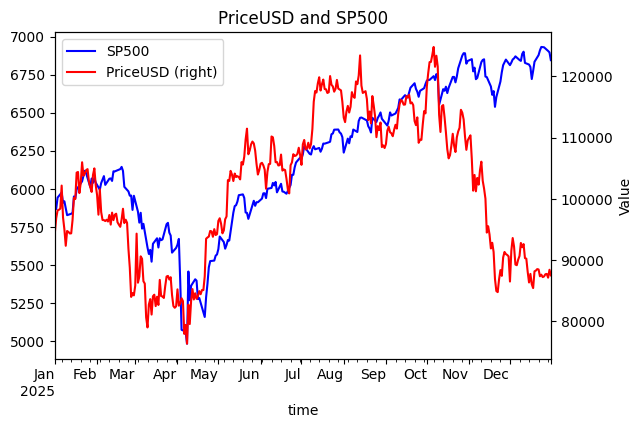

In [270]:
df_sp500_2025=df_sp500[df_sp500.index.year == 2025]
ax=df_sp500_2025.plot(y='Close', label='SP500', color='blue')
df_btc_2025.plot(y='PriceUSD', label='PriceUSD', color='red', ax=ax, secondary_y=True)
plt.title('PriceUSD and SP500')
plt.xlabel('Index')
plt.ylabel('Value')
#plt.legend()
plt.show()

Compute the correlation value for SP500 close vs PriceUSD. There seems to be significant correlation.

In [279]:
df_2 = pd.merge(df_sp500_2025, df_btc_2025,left_index=True, right_index=True)
correlation_value = df_2['PriceUSD'].corr(df_2['Close'])
correlation_value

0.42559274970984406

# Analysis based on Polymarket data and BTC data

In [386]:

file=POLYMARKET_DIR / 'finance_politics_markets.parquet'
df_markets = pd.read_parquet(file)
fix_timestamp(df_markets)

file=POLYMARKET_DIR /'finance_politics_tokens.parquet'
df_politics_tokens = pd.read_parquet(file)
fix_timestamp(df_politics_tokens)

file=POLYMARKET_DIR / 'finance_politics_trades-001.parquet'
df_politics_trades = pd.read_parquet(file)
fix_timestamp(df_politics_trades)
df_politics_trades

file=POLYMARKET_DIR /'finance_politics_odds_history.parquet'
df_finance_politics_odds_history = pd.read_parquet(file)
fix_timestamp(df_finance_politics_odds_history)
df_finance_politics_odds_history

file=POLYMARKET_DIR /'finance_politics_event_stats.parquet'
df_finance_politics_event_stats = pd.read_parquet(file)
fix_timestamp(df_finance_politics_event_stats)


Get only data related to Bitcoin and crypto.

In [311]:
df_markets_btc = df_markets[df_markets["question"].str.contains("Bitcoin|BTC|btc", case=False, na=False) | df_markets["category"].str.contains("Crypto", case=False, na=False)]
#df_markets_btc

Get Bitcoin related trades from Polymarket data. We filter trades which have positive outcomes.

In [316]:
trade1=pd.merge(df_politics_trades, df_markets_btc, on='market_id', how='inner')
trade1=pd.merge(trade1, df_politics_tokens, on=['market_id', 'token_id'], how='inner')
trade1['trade_date'] = trade1['timestamp'].dt.strftime('%Y-%m-%d')
trade1['trade_date'] = pd.to_datetime(trade1['trade_date'])
trade1['expected_size'] = trade1['size']*trade1['price']

allowed_outcomes = ['Up','Yes','Positive']
trade1=trade1[trade1['outcome'].isin(allowed_outcomes)]

Analyze for the year 2025. By aggregating trades for a given date.
<br>
Price is some sort of probability. Price*TradeQty is some sort of expectation. 

In [321]:
year=2025

year=2025

trades_yyyy = trade1[trade1['timestamp'].dt.year == year]
sell_trades_yyyy = trades_yyyy[trades_yyyy['side'] == 'SELL']
buy_trades_yyyy = trades_yyyy[trades_yyyy['side'] == 'BUY']
trades_yyyy_group_by_date = trades_yyyy.groupby('trade_date')[['price']].mean()
buy_trades_yyyy_group_by_date = buy_trades_yyyy.groupby('trade_date')[['price']].mean()
sell_trades_yyyy_group_by_date = sell_trades_yyyy.groupby('trade_date')[['price']].mean()

expected_size_buy_trades_yyyy_group_by_date = buy_trades_yyyy.groupby('trade_date')[['expected_size']].sum()
expected_size_sell_trades_yyyy_group_by_date = sell_trades_yyyy.groupby('trade_date')[['expected_size']].sum()

buy_trades_summary_yyyy = buy_trades_yyyy.groupby('trade_date').agg({
    'expected_size': ['sum'],
    'price': 'mean',
    'size': 'sum'
})

sell_trades_summary_yyyy = sell_trades_yyyy.groupby('trade_date').agg({
    'expected_size': ['sum'],
    'price': 'mean',
    'size': 'sum'
})

trades_summary_yyyy=pd.merge(buy_trades_summary_yyyy, sell_trades_summary_yyyy, left_index=True, right_index=True)

trades_summary_yyyy.rename(columns={"expected_size_x":"expected_buy_size","price_x":"buy_price","size_x":"buy_size",
                                                          "expected_size_y":"expected_sell_size","price_y":"sell_price","size_y":"sell_size"},inplace=True)

trades_summary_yyyy_flat = pd.DataFrame({
    'expected_buy_size': trades_summary_yyyy['expected_buy_size']['sum'],
    'buy_price': trades_summary_yyyy['buy_price']['mean'],
    'buy_size': trades_summary_yyyy['buy_size']['sum'],
    'expected_sell_size': trades_summary_yyyy['expected_sell_size']['sum'],
    'sell_price': trades_summary_yyyy['sell_price']['mean'],
    'sell_size': trades_summary_yyyy['sell_size']['sum'],
    
})

trades_summary_yyyy_flat.head(4)

,expected_buy_size,buy_price,buy_size,expected_sell_size,sell_price,sell_size
trade_date,,,,,,
2025-04-07,220325.605189,0.271352,6.956831e+05,111851.977980,0.344353,407463.272315
2025-04-08,120773.087787,0.262969,4.973372e+05,54387.961612,0.274101,258067.768607
2025-04-09,324275.806554,0.260437,1.266823e+06,114820.413700,0.282044,491704.704887
2025-04-10,206190.231106,0.188307,1.063212e+06,68595.086775,0.185466,428393.738190


Plot of avg buy price vs sell price. If the buy price is above sell price, it indicates there is more buying for positive outcomes in polymarket data.

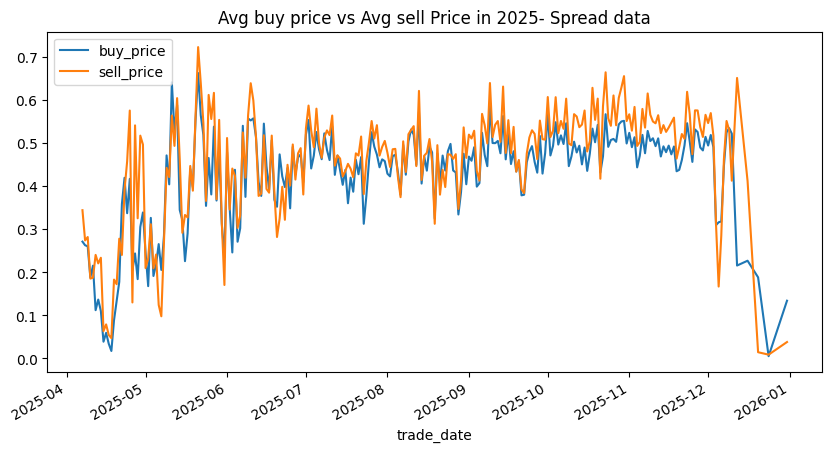

In [343]:
fig, ax = plt.subplots(figsize=(10, 5)) 
trades_summary_yyyy_flat.plot(ax=ax, y="buy_price", label="buy_price")
trades_summary_yyyy_flat.plot(ax=ax, y="sell_price", label="sell_price")

ax.set_title('Avg buy price vs Avg sell Price in 2025- Spread data')
plt.legend()
plt.show()

Check if there is any trend in buy_price vs sell_price. The data shows it is stationary.

In [338]:
check_stationarity(trades_summary_yyyy_flat['buy_price'] - trades_summary_yyyy_flat['sell_price'])

ADF Statistic: -4.491379
p-value: 0.000204
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Stationary


Plot the expected trade size for buy vs sell. This is sort of proxy for market value

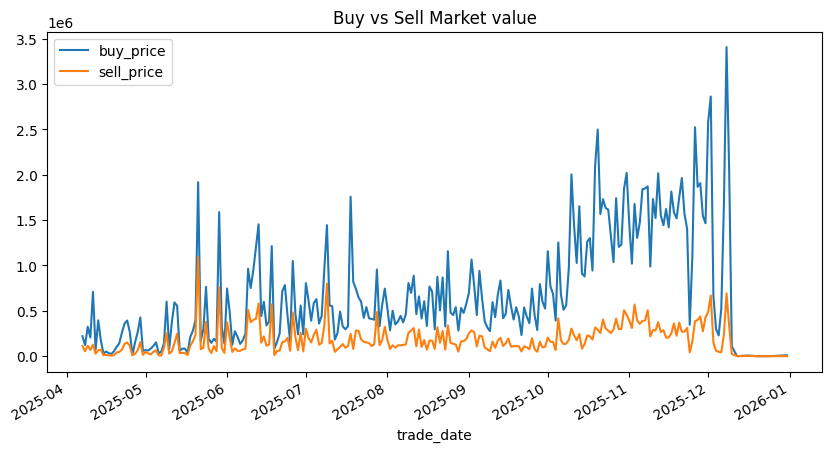

In [351]:
fig, ax = plt.subplots(figsize=(10, 5)) 
trades_summary_yyyy_flat.plot(ax=ax, y="expected_buy_size", label="buy_price")
trades_summary_yyyy_flat.plot(ax=ax, y="expected_sell_size", label="sell_price")

ax.set_title('Buy vs Sell Market value')
plt.legend()
plt.show()

We see there is a trend in the market size. The buy trades are increasing showing a trend.

In [360]:
check_stationarity(trades_summary_yyyy_flat['expected_buy_size'] - trades_summary_yyyy_flat['expected_sell_size'])

ADF Statistic: -1.601860
p-value: 0.482659
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Non-stationary


Decompose this into patterns, which detects a clear trend.

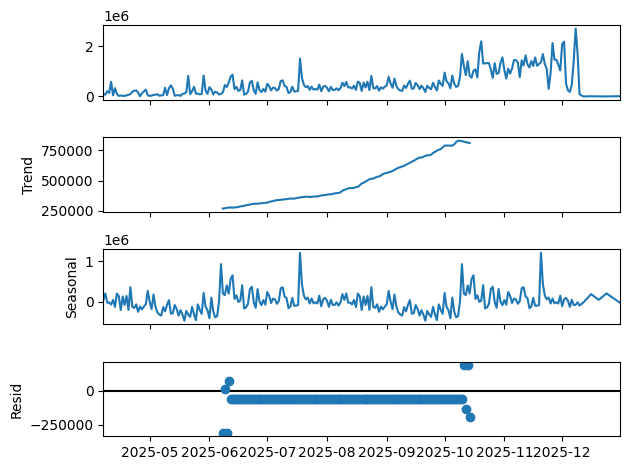

In [363]:
px=trades_summary_yyyy_flat['expected_buy_size'] - trades_summary_yyyy_flat['expected_sell_size']
result = seasonal_decompose(px, model='additive', period=125)  # Adjust period based on your data

trend = result.trend
seasonal = result.seasonal
residual = result.resid

decomposition_results = {
    'Close': {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
}

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

<b>Analyze the polymarkets odds data</b>

In [388]:
year=2025
df_finance_politics_odds_history["time"] = pd.to_datetime(df_finance_politics_odds_history["timestamp"])
df_finance_politics_odds_history=pd.merge(df_finance_politics_odds_history, df_politics_tokens, on=['market_id', 'token_id'], how='inner')
df_finance_politics_odds_history=pd.merge(df_finance_politics_odds_history, df_markets_btc, on='market_id', how='inner')
allowed_outcomes = ['Up','Yes','Positive']
df_finance_politics_odds_history=df_finance_politics_odds_history[df_finance_politics_odds_history['outcome'].isin(allowed_outcomes)]
df_finance_politics_odds_history['date'] = df_finance_politics_odds_history['timestamp'].dt.date
df_finance_politics_odds_history=df_finance_politics_odds_history.groupby(['date'])['price'].mean().to_frame()
df_finance_politics_odds_history.index = pd.to_datetime(df_finance_politics_odds_history.index)
df_finance_politics_odds_history_yyyy = df_finance_politics_odds_history[df_finance_politics_odds_history.index.year == year]

Join the trades data with odds history 

In [392]:
df_2=pd.merge(trades_summary_yyyy_flat, df_finance_politics_odds_history_yyyy,left_index=True, right_index=True)
correlation_value = df_2['buy_price'].corr(df_2['price'])
correlation_value

0.5664130683740559

We see there is a correlation between Price (from polymarket data) and price (from Odds history)

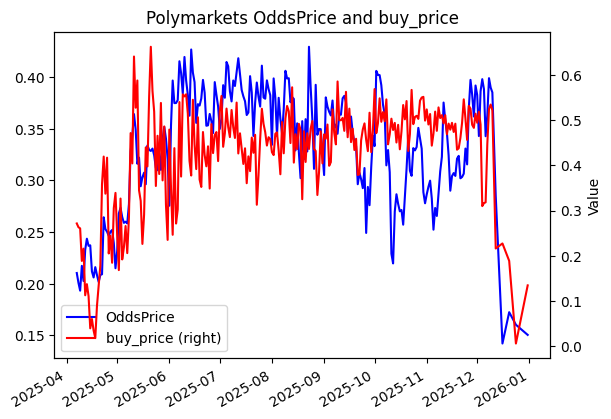

In [397]:
ax = df_2.plot(y='price', label='OddsPrice', color='blue')
df_2.plot(y='buy_price', label='buy_price', color='red', ax=ax, secondary_y=True)

plt.title('Polymarkets OddsPrice and buy_price')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

We try to determine if Odds price has a causality to buy_price. The p_values have a less than 0.05 and hence null hypothesis that there is no causality can be rejected.

In [400]:
merged_df=df_2[['buy_price', 'price']]
gc_res = grangercausalitytests(merged_df, 40)
gc_res


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5545 , p=0.0000  , df_denom=249, df_num=1
ssr based chi2 test:   chi2=17.7660 , p=0.0000  , df=1
likelihood ratio test: chi2=17.1677 , p=0.0000  , df=1
parameter F test:         F=17.5545 , p=0.0000  , df_denom=249, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5688  , p=0.0113  , df_denom=246, df_num=2
ssr based chi2 test:   chi2=9.3233  , p=0.0095  , df=2
likelihood ratio test: chi2=9.1543  , p=0.0103  , df=2
parameter F test:         F=4.5688  , p=0.0113  , df_denom=246, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8391  , p=0.0027  , df_denom=243, df_num=3
ssr based chi2 test:   chi2=14.9355 , p=0.0019  , df=3
likelihood ratio test: chi2=14.5064 , p=0.0023  , df=3
parameter F test:         F=4.8391  , p=0.0027  , df_denom=243, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8424  , p=0.0249  

{1: ({'ssr_ftest': (17.554461074152282, 3.87948103837275e-05, 249.0, 1),
   'ssr_chi2test': (17.765960605166164, 2.4981290354614928e-05, 1),
   'lrtest': (17.167672119587223, 3.422107949428401e-05, 1),
   'params_ftest': (17.554461074152247, 3.87948103837281e-05, 249.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.568780359004755, 0.01126593102398274, 246.0, 2),
   'ssr_chi2test': (9.323283496830841, 0.009450933602741176, 2),
   'lrtest': (9.154300709891004, 0.010284160787822617, 2),
   'params_ftest': (4.568780359004686, 0.011265931023983551, 246.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.839110960446341, 0.0027346659663134818, 243.0, 3),
   'ssr_chi2test': (14.935527655698584, 0.001872582155184873, 3),
   'lrtest': (14.506396664605063, 0.002290958896763323, 3),
   'params_ftest': (4.839110960446367, 0.0027346659663133968, 243.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

buy_price and price seem to be cointegrated too.

In [412]:
y0=np.log(df_2['buy_price'])
y1=np.log(df_2['price'])
y0=df_2['buy_price']
y1=df_2['price']

coint_t_statistic, p_value, critical_values = ts.coint(y0, y1, trend='c')

print(f"Cointegration Test Statistic: {coint_t_statistic}")
print(f"P-value: {p_value}")
print(f"Critical Values (1%, 5%, 10%): {critical_values}")

if p_value < 0.05:
    print("Result: Series are likely cointegrated (reject H0)")
else:
    print("Result: Series are likely NOT cointegrated (fail to reject H0)")

Cointegration Test Statistic: -2.7758899440832487
P-value: 0.1734766475500401
Critical Values (1%, 5%, 10%): [-3.94042787 -3.36048387 -3.06132299]
Result: Series are likely NOT cointegrated (fail to reject H0)


# Analysis between BTC data and polymarket data.

Since price (from odds data) seems to have causality, we try to find relation between price and btc price.

In [415]:
df_2=pd.merge(df_2, df_btc_2025,left_index=True, right_index=True)
df_2.head(2)

,expected_buy_size,buy_price,buy_size,expected_sell_size,sell_price,sell_size,price,AdrActCnt,AdrBalCnt,AssetCompletionTime,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
2025-04-07,220325.605189,0.271352,695683.085655,111851.977980,0.344353,407463.272315,0.210328,791618.0,53314065.0,1.744079e+09,...,NaN,NaN,NaN,1.984798e+07,2.442926e+06,1.940216e+11,2.079455e+07,315963.0,736035.0,3.254599e+10
2025-04-08,120773.087787,0.262969,497337.224191,54387.961612,0.274101,258067.768607,0.200775,736263.0,53345480.0,1.744166e+09,...,NaN,NaN,NaN,1.984845e+07,2.449404e+06,1.870155e+11,2.079467e+07,360926.0,806113.0,1.752911e+10


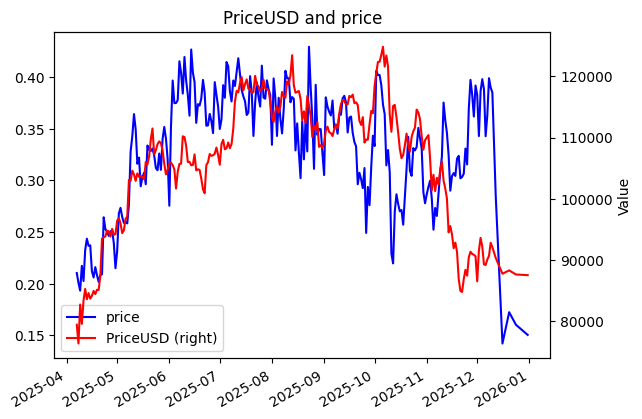

In [433]:
ax = df_2.plot(y='price', label='price', color='blue')
df_2.plot(y='PriceUSD', label='PriceUSD', color='red', ax=ax, secondary_y=True)

plt.title('PriceUSD and price')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()




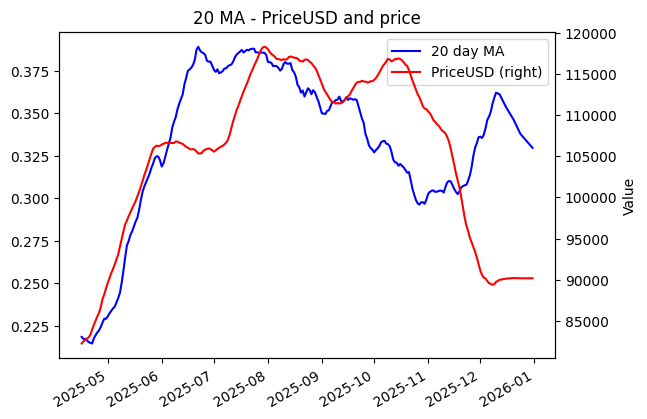

In [435]:
ma = df_2['price'].rolling(20, min_periods=20 // 2).mean().dropna().to_frame() #OK
ma_btc = df_2['PriceUSD'].rolling(20, min_periods=20 // 2).mean().dropna().to_frame()

ax = ma.plot(y='price', label='20 day MA', color='blue')
ma_btc.plot(y='PriceUSD', label='PriceUSD', color='red', ax=ax, secondary_y=True)

plt.title('20 MA - PriceUSD and price')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

From the graph, it looks like the BTC MA of PriceUSD seems to be following Price (Odds probability). We compute correlation.

In [439]:
ma_btc['PriceUSD'].corr(ma['price'])

0.6478035758595156

# Use the code provided by Trilemma, which enriches BTC Data.

In [443]:
# =============================================================================
# Constants
# =============================================================================

PRICE_COL = "PriceUSD_coinmetrics"
MVRV_COL = "CapMVRVCur"

# Strategy parameters
MIN_W = 1e-6
MA_WINDOW = 200  # 200-day simple moving average
MVRV_GRADIENT_WINDOW = 30  # Window for MVRV trend detection
MVRV_ROLLING_WINDOW = 365  # Window for MVRV Z-score normalization
MVRV_ACCEL_WINDOW = 14  # Window for acceleration calculation
DYNAMIC_STRENGTH = 5.0  # Multiplier for weight adjustments

# MVRV Zone thresholds (based on historical distribution)
MVRV_ZONE_DEEP_VALUE = -2.0  # Z-score threshold for deep value
MVRV_ZONE_VALUE = -1.0  # Z-score threshold for value
MVRV_ZONE_CAUTION = 1.5  # Z-score threshold for caution
MVRV_ZONE_DANGER = 2.5  # Z-score threshold for danger

# Volatility adjustment parameters
MVRV_VOLATILITY_WINDOW = 90  # Window for volatility calculation
MVRV_VOLATILITY_DAMPENING = (
    0.2  # How much to dampen signals in high volatility (reduced)
)

# Feature column names (for compatibility)
FEATS = [
    "price_vs_ma",
    "mvrv_zscore",
    "mvrv_gradient",
    "mvrv_acceleration",
    "mvrv_zone",
    "mvrv_volatility",
    "signal_confidence",
    "polymarket_sentiment",
]



def load_data():
    """Load BTC data from CoinMetrics CSV.

    Loads from local file: data/Coin Metrics/coinmetrics_btc.csv
    """
    BACKTEST_START = "2018-01-01"
    BACKTEST_END = "2025-12-31"
    
    # Try project root relative to this file
    #base_dir = Path(__file__).parent.parent
    #local_path = base_dir / "data" / "Coin Metrics" / "coinmetrics_btc.csv"
    local_path = Path("C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data2/coinmetrics_btc.csv")
    
    # Fallback to CWD relative (for back-compat)
    if not local_path.exists():
        local_path = Path("data/Coin Metrics/coinmetrics_btc.csv")

    if not local_path.exists():
        raise FileNotFoundError(
            f"CoinMetrics BTC data file not found at {local_path}. "
            "Please ensure the file exists in the data/Coin Metrics/ directory."
        )

    logging.info(f"Loading CoinMetrics BTC data from local file: {local_path}")
    df = pd.read_csv(local_path)

    # Set time as index
    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.index = df.index.normalize().tz_localize(None)

    # Remove duplicates and sort
    df = df.loc[~df.index.duplicated(keep="last")].sort_index()

    # Use PriceUSD column from CoinMetrics (complete 2025 data)
    if "PriceUSD" not in df.columns:
        raise ValueError("PriceUSD column not found in CoinMetrics data")

    # Rename PriceUSD to PriceUSD_coinmetrics for compatibility
    df["PriceUSD_coinmetrics"] = df["PriceUSD"]

    # Assert all dates from BACKTEST_START to the latest available date have BTC-USD prices
    latest_date = df.index.max()
    backtest_dates = df.index[
        (df.index >= pd.to_datetime(BACKTEST_START)) & (df.index <= latest_date)
    ]
    missing_prices = df.loc[backtest_dates, "PriceUSD_coinmetrics"].isnull()
    if missing_prices.any():
        first_missing = df.loc[backtest_dates, "PriceUSD_coinmetrics"][
            missing_prices
        ].index.min()
        logging.warning(
            f"Missing BTC-USD prices for {missing_prices.sum()} dates from {BACKTEST_START} to {latest_date.date()}. "
            f"First missing date: {first_missing.date()}"
        )

    logging.info(
        f"Loaded CoinMetrics data: {len(df)} rows, {df.index.min().date()} to {df.index.max().date()}"
    )
    return df

def precompute_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute MVRV and MA features for weight calculation.

    Features (all lagged 1 day to prevent look-ahead bias):
    - price_vs_ma: Normalized distance from 200-day MA, clipped to [-1, 1]
    - mvrv_zscore: MVRV Z-score (365-day window), clipped to [-4, 4]
    - mvrv_gradient: Smoothed MVRV trend direction in [-1, 1]
    - mvrv_acceleration: Second derivative of MVRV gradient (momentum)
    - mvrv_zone: Discrete zone classification [-2, -1, 0, 1, 2]
    - polymarket_sentiment: Normalized sentiment from BTC market activity [0, 1]

    Args:
        df: DataFrame with price and MVRV columns

    Returns:
        DataFrame with price and computed features
    """
    if PRICE_COL not in df.columns:
        raise KeyError(f"'{PRICE_COL}' not found. Available: {list(df.columns)}")

    # Filter to valid date range
    price = df[PRICE_COL].loc["2010-07-18":].copy()

    # 200-day MA and distance
    ma = price.rolling(MA_WINDOW, min_periods=MA_WINDOW // 2).mean()
    with np.errstate(divide="ignore", invalid="ignore"):
        price_vs_ma = ((price / ma) - 1).clip(-1, 1).fillna(0)

    # MVRV features
    if MVRV_COL in df.columns:
        mvrv = df[MVRV_COL].loc[price.index]

        # Core Z-score (365-day window)
        mvrv_z = zscore(mvrv, MVRV_ROLLING_WINDOW).clip(-4, 4)

        # Smoothed gradient using EMA
        gradient_raw = mvrv_z.diff(MVRV_GRADIENT_WINDOW)
        gradient_smooth = gradient_raw.ewm(
            span=MVRV_GRADIENT_WINDOW, adjust=False
        ).mean()
        mvrv_gradient = np.tanh(gradient_smooth * 2).fillna(0)

        # MVRV acceleration (second derivative - momentum detection)
        accel_raw = mvrv_gradient.diff(MVRV_ACCEL_WINDOW)
        mvrv_acceleration = accel_raw.ewm(span=MVRV_ACCEL_WINDOW, adjust=False).mean()
        mvrv_acceleration = np.tanh(mvrv_acceleration * 3).fillna(0)

        # Zone classification
        mvrv_zone = pd.Series(
            classify_mvrv_zone(mvrv_z.values),
            index=mvrv_z.index,
        )

        # MVRV volatility (for signal dampening in uncertain periods)
        mvrv_volatility = compute_mvrv_volatility(mvrv_z, MVRV_VOLATILITY_WINDOW)

        # Signal confidence (computed after lag, using lagged values)
        # Will be computed after lag is applied
        signal_confidence = pd.Series(0.5, index=price.index)
    else:
        mvrv_z = pd.Series(0.0, index=price.index)
        mvrv_gradient = pd.Series(0.0, index=price.index)
        mvrv_acceleration = pd.Series(0.0, index=price.index)
        mvrv_zone = pd.Series(0, index=price.index)
        mvrv_volatility = pd.Series(0.5, index=price.index)
        signal_confidence = pd.Series(0.5, index=price.index)

    # Load Polymarket sentiment (if available)
    try:
        polymarket_df = load_polymarket_btc_sentiment()
        if not polymarket_df.empty:
            # Merge with price index, fill missing dates with neutral (0.5)
            polymarket_sentiment = polymarket_df["polymarket_sentiment"].reindex(
                price.index, fill_value=0.5
            )
        else:
            polymarket_sentiment = pd.Series(0.5, index=price.index)
    except (ImportError, FileNotFoundError, Exception) as e:
        # If Polymarket data not available, use neutral sentiment
        logging.warning(f"Polymarket sentiment not available: {e}")
        polymarket_sentiment = pd.Series(0.5, index=price.index)

    # Build and lag features
    features = pd.DataFrame(
        {
            PRICE_COL: price,
            "price_ma": ma,
            "price_vs_ma": price_vs_ma,
            "mvrv_zscore": mvrv_z,
            "mvrv_gradient": mvrv_gradient,
            "mvrv_acceleration": mvrv_acceleration,
            "mvrv_zone": mvrv_zone,
            "mvrv_volatility": mvrv_volatility,
            "signal_confidence": signal_confidence,
            "polymarket_sentiment": polymarket_sentiment,
        },
        index=price.index,
    )

    # Lag signals by 1 day to prevent look-ahead bias
    signal_cols = [
        "price_vs_ma",
        "mvrv_zscore",
        "mvrv_gradient",
        "mvrv_acceleration",
        "mvrv_zone",
        "mvrv_volatility",
        "polymarket_sentiment",
    ]
    features[signal_cols] = features[signal_cols].shift(1)

    # Fill NaN values with appropriate defaults
    features["mvrv_zone"] = features["mvrv_zone"].fillna(0)
    features["mvrv_volatility"] = features["mvrv_volatility"].fillna(0.5)
    features["polymarket_sentiment"] = features["polymarket_sentiment"].fillna(0.5)
    features = features.fillna(0)

    # Compute signal confidence using lagged values (no look-ahead)
    features["signal_confidence"] = compute_signal_confidence(
        features["mvrv_zscore"].values,
        features["mvrv_gradient"].values,
        features["price_vs_ma"].values,
    )

    return features



def load_polymarket_data() -> dict[str, pd.DataFrame]:
    """Load all raw Polymarket data files.
    
    Returns:
        Dictionary mapping file names to DataFrames:
        - 'markets': finance_politics_markets.parquet
        - 'tokens': finance_politics_tokens.parquet
        - 'trades': finance_politics_trades.parquet
        - 'odds_history': finance_politics_odds_history.parquet
        - 'event_stats': finance_politics_event_stats.parquet
        - 'summary': finance_politics_summary.parquet
        
    Missing files will be logged as warnings and excluded from the returned dictionary.
    """
    from pathlib import Path
    #base_dir = Path(__file__).parent.parent
    #polymarket_dir = base_dir / "data" / "Polymarket"
    
    
    # Fallback to CWD relative
    #if not polymarket_dir.exists():
    #    polymarket_dir = Path("data/Polymarket")
    #polymarket_dir=Path('C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data/Polymarket')
    polymarket_dir=Path('C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data2')
    
    if not polymarket_dir.exists():
        logging.warning(
            f"Polymarket data directory not found at {polymarket_dir}. "
            "Returning empty dictionary."
        )
        return {}
    
    # Map of file keys to actual filenames
    file_map = {
        "markets": "finance_politics_markets.parquet",
        "tokens": "finance_politics_tokens.parquet",
        "trades": "finance_politics_trades.parquet",
        "odds_history": "finance_politics_odds_history.parquet",
        "event_stats": "finance_politics_event_stats.parquet",
        "summary": "finance_politics_summary.parquet",
    }
    
    data = {}
    for key, filename in file_map.items():
        file_path = polymarket_dir / filename
        if file_path.exists():
            try:
                logging.info(f"Loading Polymarket data: {filename}")
                df = pd.read_parquet(file_path)
                
                # Fix timestamp corruption (seconds sometimes interpreted as milliseconds)
                for col in df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if pd.api.types.is_datetime64_any_dtype(df[col]):
                            if not df[col].empty and df[col].max() < pd.Timestamp("2020-01-01"):
                                logging.info(f"  Fixing corrupted timestamps in column: {col}")
                                # Scale up by 1000 to correct seconds-as-ms bug.
                                # Use astype('datetime64[ns]') to ensure we are working with nanoseconds
                                # before scaling, then convert back.
                                ns_values = df[col].values.astype("datetime64[ns]").astype("int64")
                                df[col] = pd.to_datetime(ns_values * 1000)
                                
                            # Enforce 2020+ constraint (replace placeholders/zeros with NaT)
                            if not df[col].empty:
                                mask = df[col] < pd.Timestamp("2020-01-01")
                                if mask.any():
                                    df.loc[mask, col] = pd.NaT
                                
                data[key] = df
                logging.info(f"  Loaded {len(df)} rows from {filename}")
            except Exception as e:
                logging.warning(f"Failed to load {filename}: {e}")
        else:
            logging.warning(f"Polymarket file not found: {file_path}")
    
    if data:
        logging.info(f"Successfully loaded {len(data)} Polymarket data file(s)")
    else:
        logging.warning("No Polymarket data files were loaded")
    
    return data

def zscore(series: pd.Series, window: int) -> pd.Series:
    """Compute rolling z-score."""
    mean = series.rolling(window, min_periods=window // 2).mean()
    std = series.rolling(window, min_periods=window // 2).std()
    return ((series - mean) / std).fillna(0)

def classify_mvrv_zone(mvrv_zscore: np.ndarray) -> np.ndarray:
    """Classify MVRV into discrete zones for regime detection.

    Zones:
    - -2 (deep_value): Z < -2.0 (historically rare, extreme buying opportunity)
    - -1 (value): -2.0 <= Z < -1.0 (undervalued, increase buying)
    -  0 (neutral): -1.0 <= Z < 1.5 (fair value, normal DCA)
    - +1 (caution): 1.5 <= Z < 2.5 (overvalued, reduce buying)
    - +2 (danger): Z >= 2.5 (extreme overvaluation, minimize buying)

    Args:
        mvrv_zscore: Array of MVRV Z-scores

    Returns:
        Array of zone classifications in [-2, -1, 0, 1, 2]
    """
    return np.select(
        [
            mvrv_zscore < MVRV_ZONE_DEEP_VALUE,
            mvrv_zscore < MVRV_ZONE_VALUE,
            mvrv_zscore < MVRV_ZONE_CAUTION,
            mvrv_zscore < MVRV_ZONE_DANGER,
        ],
        [-2, -1, 0, 1],
        default=2,
    )


def compute_mvrv_volatility(mvrv_zscore: pd.Series, window: int) -> pd.Series:
    """Compute rolling volatility of MVRV Z-score.

    High volatility periods suggest uncertainty - signals should be dampened.
    Low volatility periods suggest conviction - signals can be amplified.

    Args:
        mvrv_zscore: MVRV Z-score series
        window: Rolling window for volatility calculation

    Returns:
        Normalized volatility in [0, 1] where 1 = high volatility
    """
    vol = mvrv_zscore.rolling(window, min_periods=window // 4).std()
    # Normalize to [0, 1] using historical quantiles
    vol_pct = vol.rolling(window * 4, min_periods=window).apply(
        lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1)
        if len(x) > 1
        else 0.5,
        raw=False,
    )
    return vol_pct.fillna(0.5)


def compute_signal_confidence(
    mvrv_zscore: np.ndarray,
    mvrv_gradient: np.ndarray,
    price_vs_ma: np.ndarray,
) -> np.ndarray:
    """Compute confidence score based on signal agreement.

    When multiple signals agree, confidence is high:
    - Low Z-score + Rising gradient = High confidence buy
    - High Z-score + Falling gradient = High confidence reduce

    Args:
        mvrv_zscore: MVRV Z-score in [-4, 4]
        mvrv_gradient: Trend direction in [-1, 1]
        price_vs_ma: Price vs MA in [-1, 1]

    Returns:
        Confidence score in [0, 1] where 1 = all signals strongly agree
    """
    # Normalize all signals to [-1, 1] where negative = buy signal
    z_signal = -mvrv_zscore / 4  # Normalize to [-1, 1]
    ma_signal = -price_vs_ma  # Below MA = buy signal

    # Gradient indicates momentum direction
    # Positive gradient with buy signals = confirmation
    # Negative gradient with buy signals = divergence (lower confidence)
    gradient_alignment = np.where(
        z_signal < 0,  # Buy signal from Z-score
        np.where(mvrv_gradient > 0, 1.0, 0.5),  # Rising = confirmation
        np.where(mvrv_gradient < 0, 1.0, 0.5),  # Falling = confirmation for sell
    )

    # Calculate agreement: how many signals point the same direction?
    signals = np.stack([z_signal, ma_signal], axis=0)
    signal_std = signals.std(axis=0)

    # Low std = high agreement, high std = disagreement
    # Transform std to confidence: confidence = 1 - normalized_std
    max_std = 1.0  # Maximum possible std when signals fully disagree
    agreement = 1.0 - np.clip(signal_std / max_std, 0, 1)

    # Combine agreement with gradient alignment
    confidence = agreement * 0.7 + gradient_alignment * 0.3

    return np.clip(confidence, 0, 1)

def load_polymarket_btc_sentiment() -> pd.DataFrame:
    """Load Polymarket BTC-related markets and compute daily sentiment.
    
    This is a model-specific function that processes raw Polymarket data
    to extract BTC sentiment signals. It uses the general load_polymarket_data()
    function from template/prelude_template.py.
    
    Aggregates BTC-related prediction markets by creation date to compute:
    - daily_market_count: number of new BTC markets created each day
    - daily_volume: total volume of BTC markets created each day
    - polymarket_sentiment: normalized sentiment score [0, 1]
    
    Returns:
        DataFrame indexed by date with sentiment features.
        Returns empty DataFrame if Polymarket data not found.
    """
    # Load raw Polymarket data using the general function
    polymarket_data = load_polymarket_data()
    
    if "markets" not in polymarket_data:
        logging.warning(
            "Polymarket markets data not found. "
            "Polymarket sentiment will be neutral (0.0) for all dates."
        )
        return pd.DataFrame()
    
    markets_df = polymarket_data["markets"]
    
    # Filter to BTC-related markets
    btc_markets = markets_df[
        markets_df["question"].str.contains("Bitcoin|BTC|btc", case=False, na=False)
    ].copy()
    
    logging.info(f"Found {len(btc_markets)} BTC-related markets in Polymarket data")
    
    if btc_markets.empty:
        logging.warning("No BTC-related markets found in Polymarket data")
        return pd.DataFrame()
    
    # Extract creation date (normalize to date only)
    btc_markets["created_date"] = pd.to_datetime(btc_markets["created_at"]).dt.normalize()
    
    # Aggregate by creation date
    daily_stats = btc_markets.groupby("created_date").agg(
        daily_market_count=("market_id", "count"),
        daily_volume=("volume", "sum")
    ).reset_index()
    
    # Compute normalized sentiment score
    # High market creation activity = high sentiment
    # Use rolling 30-day percentile to normalize
    daily_stats = daily_stats.set_index("created_date").sort_index()
    
    # Compute rolling percentiles (30-day window)
    daily_stats["market_count_pct"] = (
        daily_stats["daily_market_count"]
        .rolling(30, min_periods=1)
        .apply(lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1) if len(x) > 1 else 0.5)
    )
    
    daily_stats["volume_pct"] = (
        daily_stats["daily_volume"]
        .rolling(30, min_periods=1)
        .apply(lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1) if len(x) > 1 else 0.5)
    )
    
    # Combine into single sentiment score (average of percentiles)
    daily_stats["polymarket_sentiment"] = (
        daily_stats["market_count_pct"] * 0.5 + daily_stats["volume_pct"] * 0.5
    )
    
    # Fill NaN with neutral (0.5)
    daily_stats["polymarket_sentiment"] = daily_stats["polymarket_sentiment"].fillna(0.5)
    
    logging.info(
        f"Polymarket sentiment computed: {len(daily_stats)} days, "
        f"{daily_stats.index.min().date()} to {daily_stats.index.max().date()}"
    )
    
    return daily_stats[["polymarket_sentiment"]]

In [447]:
df_btc['PriceUSD_coinmetrics'] = df_btc['PriceUSD']
df_btc_with_features = precompute_features(df_btc)

In [451]:
df_btc_with_features.corr()

,PriceUSD_coinmetrics,price_ma,price_vs_ma,mvrv_zscore,mvrv_gradient,mvrv_acceleration,mvrv_zone,mvrv_volatility,signal_confidence,polymarket_sentiment
PriceUSD_coinmetrics,1.000000,0.966435,-0.064248,-0.002122,-0.119277,-0.022063,-0.034631,-0.061100,0.172224,0.038066
price_ma,0.966435,1.000000,-0.187190,-0.145521,-0.159968,-0.013665,-0.170266,-0.096818,0.200753,0.041483
price_vs_ma,-0.064248,-0.187190,1.000000,0.678629,0.134386,-0.055306,0.642606,0.392189,-0.458385,-0.000590
mvrv_zscore,-0.002122,-0.145521,0.678629,1.000000,0.373105,0.060575,0.896778,0.332178,0.066408,-0.006009
mvrv_gradient,-0.119277,-0.159968,0.134386,0.373105,1.000000,0.550891,0.421557,-0.007534,0.238595,0.021112
mvrv_acceleration,-0.022063,-0.013665,-0.055306,0.060575,0.550891,1.000000,0.075221,-0.087699,0.157396,-0.000765
mvrv_zone,-0.034631,-0.170266,0.642606,0.896778,0.421557,0.075221,1.000000,0.267656,0.055980,0.007530
mvrv_volatility,-0.061100,-0.096818,0.392189,0.332178,-0.007534,-0.087699,0.267656,1.000000,-0.049916,-0.031820
signal_confidence,0.172224,0.200753,-0.458385,0.066408,0.238595,0.157396,0.055980,-0.049916,1.000000,0.012627
polymarket_sentiment,0.038066,0.041483,-0.000590,-0.006009,0.021112,-0.000765,0.007530,-0.031820,0.012627,1.000000


PriceUSD has a high correlation with Price_ma and signal_confidence. It also have correlation with polymarket_sentiment.

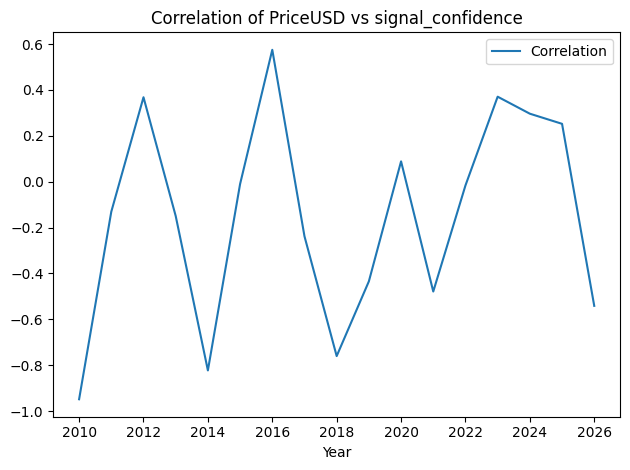

In [469]:
tmp=[]
years=[]
correlation_cols=["PriceUSD_coinmetrics","signal_confidence","polymarket_sentiment"]
for year in df_btc_with_features.index.year.unique():

    df_btc_with_features_year=df_btc_with_features[df_btc_with_features.index.year == year]
    correlation_matrix = df_btc_with_features_year[correlation_cols].corr()
    tmp.append(correlation_matrix["PriceUSD_coinmetrics"]["signal_confidence"])
    years.append(year)

my_dict = {
    'Year': years,
    'Correlation': tmp
}

# Create the DataFrame

df_2d = pd.DataFrame(my_dict)
df_2d.set_index('Year', inplace=True)

df_2d.plot()
plt.title('Correlation of PriceUSD vs signal_confidence')
plt.tight_layout()
plt.show()

We see that correlation is not consistent, it keeps changing every year. 
<br>
Also it seems to change direction. From the graph we see that this seems to have a period of 4 years.

There is no granger causality due to signal_confidence, but there is a granger causality due to polymarket_sentiment.

In [486]:
ts_df = pd.DataFrame(columns=['PriceUSD_coinmetrics', 'polymarket_sentiment'], data=zip(df_btc_with_features['PriceUSD_coinmetrics'],df_btc_with_features['polymarket_sentiment']))
gc_res = grangercausalitytests(ts_df, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7099  , p=0.3995  , df_denom=5656, df_num=1
ssr based chi2 test:   chi2=0.7103  , p=0.3993  , df=1
likelihood ratio test: chi2=0.7103  , p=0.3994  , df=1
parameter F test:         F=0.7099  , p=0.3995  , df_denom=5656, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9640  , p=0.0190  , df_denom=5653, df_num=2
ssr based chi2 test:   chi2=7.9350  , p=0.0189  , df=2
likelihood ratio test: chi2=7.9295  , p=0.0190  , df=2
parameter F test:         F=3.9640  , p=0.0190  , df_denom=5653, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9428  , p=0.0317  , df_denom=5650, df_num=3
ssr based chi2 test:   chi2=8.8394  , p=0.0315  , df=3
likelihood ratio test: chi2=8.8325  , p=0.0316  , df=3
parameter F test:         F=2.9428  , p=0.0317  , df_denom=5650, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6642  , p=0.

In [500]:
#df_btc_with_features.index

In [504]:
year=2025
df_btc_with_features_yyyy=df_btc_with_features[df_btc_with_features.index.year == year]
#df_btc_with_features_yyyy.head(2)
df_2=pd.merge(df_2, df_btc_with_features_yyyy,left_index=True, right_index=True)
df_2.head(2)

,expected_buy_size,buy_price,buy_size,expected_sell_size,sell_price,sell_size,price,AdrActCnt,AdrBalCnt,AssetCompletionTime,...,PriceUSD_coinmetrics,price_ma,price_vs_ma,mvrv_zscore,mvrv_gradient,mvrv_acceleration,mvrv_zone,mvrv_volatility,signal_confidence,polymarket_sentiment
2025-04-07,220325.605189,0.271352,695683.085655,111851.977980,0.344353,407463.272315,0.210328,791618.0,53314065.0,1.744079e+09,...,79421.804411,86807.713708,-0.101198,-1.619645,-0.875808,0.180656,-1.0,0.788301,0.893700,0.500000
2025-04-08,120773.087787,0.262969,497337.224191,54387.961612,0.274101,258067.768607,0.200775,736263.0,53345480.0,1.744166e+09,...,76351.429530,86873.701097,-0.085084,-1.473095,-0.871339,0.196958,-1.0,0.802228,0.900883,0.637931


Analyze correlation between Odds/Price and signal_confidence.

In [512]:
correlation_coefficient = df_2['price'].corr(df_2['signal_confidence'])
correlation_coefficient


0.15213955790068706

Compute the correlation between the entire dataframe.

In [534]:
x=df_2.corr()["PriceUSD_coinmetrics"].to_dict()
sorted_dict_desc = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}


In [536]:
sorted_dict_desc

{'IssTotUSD': 0.778676969908218,
 'PriceBTC': nan,
 'PriceUSD': 1.0,
 'ReferenceRate': nan,
 'ReferenceRateETH': nan,
 'ReferenceRateEUR': nan,
 'ReferenceRateUSD': nan,
 'PriceUSD_coinmetrics': 1.0,
 'CapMrktEstUSD': 0.9998857377092571,
 'CapMrktCurUSD': 0.9998853957969399,
 'SplyExUSD': 0.966253684549396,
 'ROI1yr': 0.8684895382684061,
 'price_vs_ma': 0.8115872730792291,
 'CapMVRVCur': 0.7239287710660492,
 'SplyExNtv': 0.6350326042587162,
 'mvrv_zscore': 0.6270703233256757,
 'mvrv_zone': 0.6002495184553994,
 'price': 0.5578409327447137,
 'buy_price': 0.5376153748381559,
 'sell_price': 0.4685514689445368,
 'ROI30d': 0.33033921593627247,
 'signal_confidence': 0.25542001614033916,
 'FlowOutExUSD': 0.2516238889227474,
 'FlowInExUSD': 0.24900851766720222,
 'mvrv_gradient': 0.2160323651406943,
 'price_ma': 0.14489452925820007,
 'TxCnt': 0.14276176170031396,
 'IssTotNtv': 0.11584023243122551,
 'BlkCnt': 0.1158402324312252,
 'AdrActCnt': 0.1130782481145067,
 'polymarket_sentiment': 0.0991591

Based on the correlation data of PriceUSD_coinmetrics with other attributes, we can further analyze based on the highest correlations.

<html>
<table>
  <caption><b>Correlation data of PriceUSD_coinmetrics with other attributes</b></caption>
  <thead>
    <tr>
      <th>Attribute</th>
      <th>Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>IssTotUSD</td>
      <td>0.778676969908218</td>
    </tr>
    <tr>
      <td>buy_size</td>
      <td>-0.1472486433523933</td>
    </tr>  
    <tr>
      <td>SplyExUSD</td>
      <td>0.966253684549396</td>
    </tr> 
    <tr>
      <td>ROI1yr</td>
      <td>0.8684895382684061</td>
    </tr> 
    <tr>
      <td>SplyExNtv</td>
      <td>0.6350326042587162</td>
    </tr> 
    <tr>
      <td>mvrv_zscore</td>
      <td>0.6270703233256757</td>
    </tr>     
    <tr>
      <td>mvrv_zone/td>
      <td>0.6002495184553994</td>
    </tr>     
    <tr>
      <td>price/td>
      <td>0.5578409327447137</td>
    </tr>     
    <tr>
      <td>buy_price/td>
      <td>0.5376153748381559</td>
    </tr>     
    <tr>
      <td>sell_price/td>
      <td>0.4685514689445368</td>
    </tr>     
    <tr>
      <td>ROI30d/td>
      <td>0.33033921593627247</td>
    </tr>  
    <tr>
      <td>signal_confidence</td>
      <td>0.25542001614033916</td>
    </tr>  
122551,      
  </tbody>
</table>
</html>